In [1]:
import os
import sys
import time

import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from tqdm import tqdm_notebook as tqdm

from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import rotate as sc_rotate
from torchvision import datasets, transforms
from scipy.optimize import curve_fit, least_squares, minimize

In [2]:
from radioreader import *
from methods import *
from kittler import kittler_float

In [3]:
directory = 'unlrg'
ext = 'fits'
names = glob.glob('{0}/*.{1}*'.format(directory, ext))

In [4]:
images = []
for n in tqdm(range(len(names))):
    im = readImg(names[n], normalize=True, sz=128)
    k = kittler_float(im, copy=False)
    images.append( np.expand_dims(k, axis=0) )
    del im
    del k
# images = np.array(images)

In [5]:
im_tensor = torch.tensor(images)
im_tensor.shape

torch.Size([14245, 1, 128, 128])

In [6]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

#arguments
batch_size = 64
test_batch_size = 64

ts = list(im_tensor.shape)
imh, imw = ts[2], ts[3]
print(im_tensor.shape)
print('imh, imw = ',imh, imw)

epochs = 100
learning_rate = 0.001
momentum = 0.9 # 'SGD momentum'
latent_space=16

cuda
torch.Size([14245, 1, 128, 128])
imh, imw =  128 128


In [7]:
class AutoEncoder(nn.Module):
    def __init__(self, height, width, device):
        super(AutoEncoder, self).__init__()

        self.height = height
        self.width = width
        self.device = device

        self.feat_sz = (imh - 6) * (imw - 6)
        
        # Init model layers
        self.down1 = nn.Conv2d( 1,  8, 3) #shape -2
        self.down2 = nn.Conv2d( 8, 16, 3) #shape -2
        self.down3 = nn.Conv2d(16, 16, 3) #shape -2
        
        self.latentd = nn.Linear(16 * self.feat_sz, 16)
        #decoder
        self.latentu = nn.Linear(16, self.feat_sz * 16)
        
        self.up3   = nn.ConvTranspose2d(16, 16, 3)
        self.up2   = nn.ConvTranspose2d(16, 8, 3)
        self.up1   = nn.ConvTranspose2d(8, 1, 3)
        
    def encode(self, x, params):
        x = F.relu(self.down1(x))
        x = F.relu(self.down2(x))
        x = F.relu(self.down3(x))
        x =  x.view(-1, 16 * (imh - 6) * (imw - 6)) #flatten
        x = self.latentd(x)
        x = self.feature_transformer(x, params)
        return x
    
    def decode(self, x):
        x = self.latentu(x)
        x = x.view(-1, 16, (imh - 6), (imw - 6))
        x = F.relu(self.up3(x))
        x = F.relu(self.up2(x))
        x = torch.sigmoid(self.up1(x))
        return x

    def forward(self, x, params):
        return self.decode(self.encode(x, params))
    
    def feature_transformer(self, input, params):
        """For now we assume the params are just a single rotation angle

        Args:
            input: [N,c] tensor, where c = 2*int
            params: [N,1] tensor, with values in [0,2*pi)
        Returns:
            [N,c] tensor
        """
        # First reshape activations into [N,c/2,2,1] matrices
        x = input.view(input.size(0),input.size(1)//2,2,1)
        # Construct the transformation matrix
        sin = torch.sin(params)
        cos = torch.cos(params)
        transform = torch.cat([sin, -cos, cos, sin], 1)
        transform = transform.view(transform.size(0),1,2,2).to(self.device)
        # Multiply: broadcasting taken care of automatically
        # [N,1,2,2] @ [N,channels/2,2,1]
        output = torch.matmul(transform, x)
        # Reshape and return
        return output.view(input.size())

In [8]:
model = AutoEncoder(imh, imw, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
def rotate_tensor(input):
    """Nasty hack to rotate images in a minibatch, this should be parallelized
    and set in PyTorch

    Args:
        input: [N,c,h,w] **numpy** tensor
    Returns:
        rotated output and angles in radians
    """
    angles = 2*np.pi*np.random.rand(input.shape[0])
    angles = angles.astype(np.float32)
    outputs = []
    for i in range(input.shape[0]):
        output = sc_rotate(input[i,...], 180*angles[i]/np.pi, axes=(1,2), reshape=False)
        outputs.append(output)
    return np.stack(outputs, 0), angles

In [10]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        # Reshape data
        targets, angles = rotate_tensor(data.numpy())
        targets = torch.from_numpy(targets).to(device, dtype=torch.float)
        angles = torch.from_numpy(angles).to(device)
        angles = angles.view(angles.size(0), 1)

        # Forward pass
        data = data.to(device, dtype=torch.float)
        optimizer.zero_grad()
        output = model(data, angles)
#         print(output.shape, targets.shape)
#         return

        # Binary cross entropy loss
        loss_fnc = nn.BCELoss(reduction='sum')
        loss = loss_fnc(output, targets)

        # Backprop
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            sys.stdout.write('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\r'
                .format(epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            sys.stdout.flush()

In [11]:
%%time

train_loader = torch.utils.data.DataLoader(im_tensor, batch_size=batch_size, shuffle=True)

for epoch in range(1, epochs + 1):
    start = time.time()
    train(model, device, train_loader, optimizer, epoch)
    end = time.time()
    sys.stdout.write('\n Time: {0:.2f}s\n'.format(end - start))

Train Epoch: 1 [14080/14245 (99%)]	Loss: 10009.1171880
 Time: 36.47s
Train Epoch: 2 [14080/14245 (99%)]	Loss: 10158.850586
 Time: 35.45s
Train Epoch: 3 [14080/14245 (99%)]	Loss: 10092.837891
 Time: 35.39s
Train Epoch: 4 [14080/14245 (99%)]	Loss: 6920.1894531
 Time: 35.40s
Train Epoch: 5 [14080/14245 (99%)]	Loss: 9233.6298839
 Time: 35.43s
Train Epoch: 6 [14080/14245 (99%)]	Loss: 8621.502930
 Time: 35.42s
Train Epoch: 7 [14080/14245 (99%)]	Loss: 8271.1875009
 Time: 35.42s
Train Epoch: 8 [14080/14245 (99%)]	Loss: 8080.8974616
 Time: 35.32s
Train Epoch: 9 [14080/14245 (99%)]	Loss: 6547.7890620
 Time: 35.28s
Train Epoch: 10 [14080/14245 (99%)]	Loss: 9069.1289062
 Time: 35.26s
Train Epoch: 11 [14080/14245 (99%)]	Loss: 8061.729492
 Time: 35.31s
Train Epoch: 12 [14080/14245 (99%)]	Loss: 7319.8256841
 Time: 35.28s
Train Epoch: 13 [14080/14245 (99%)]	Loss: 6211.3144535
 Time: 35.30s
Train Epoch: 14 [14080/14245 (99%)]	Loss: 7149.8188484
 Time: 35.28s
Train Epoch: 15 [14080/14245 (99%)]	Loss: 73

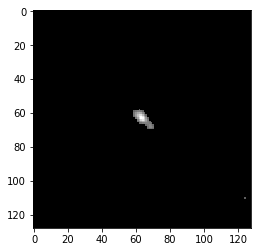

In [23]:
l = next(iter(train_loader))
l00 = l[:1,:,:]
plt.imshow(l00.numpy()[0, 0,:,:], cmap='gray')
plt.show()

In [24]:
n_rot = 32
with torch.no_grad():
    angles = torch.linspace(0, 2*np.pi, steps=n_rot)
    angles = angles.view(n_rot, 1)

    data = l00[0]
    data = data.view(data.size(0), -1)
    data = data.repeat(n_rot, 1)
    data = data.view(-1, 1, imh, imw).to(device, dtype=torch.float)

    output = model.encode(data, angles)
    output = output.cpu()

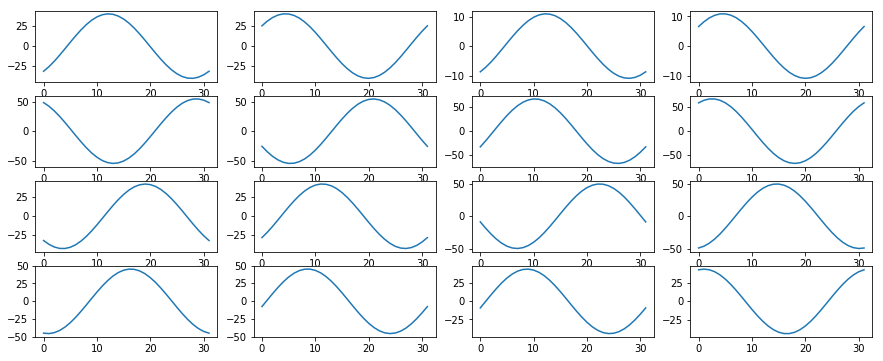

In [25]:
o_np = output.numpy()
f, ax = plt.subplots(4, 4, figsize=(15, 6))
for i in range(4): 
    for j in range(4):
        ax[i][j].plot(o_np[:,i*4 + j])

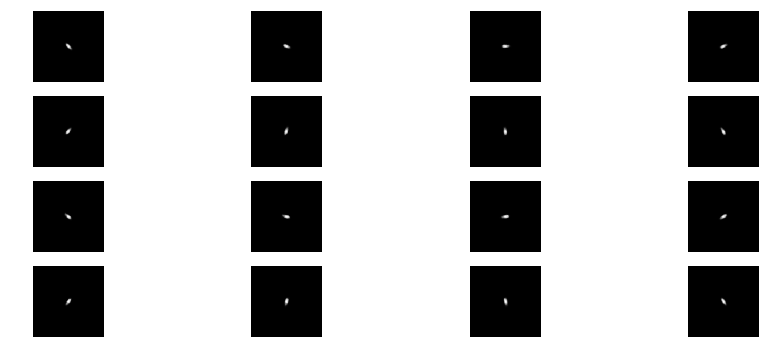

In [26]:
with torch.no_grad():
    dec = model.decode(output.to(device))
    dec = dec.cpu().view(-1,1,imh,imw)
d_np = dec.numpy()

f, ax = plt.subplots(4, 4, figsize=(15, 6))
for i in range(4): 
    for j in range(4):
        ax[i][j].imshow(d_np[2*(i*4 + j),0], cmap='gray')
        ax[i][j].axis('off')

In [16]:
torch.save(model.state_dict(), 'unlrg_linear_model')